In [8]:
import matplotlib.pyplot as plt
import netCDF4
import os, glob
import numpy as np
from scipy.interpolate import griddata
import h5py

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [9]:
CMROOT = r"C:\Users\axt5780\OneDrive - The Pennsylvania State University\PIML_project\IMERG_vectors"
CMROOT = '/glade/work/jpan/IMERG_vecs/'
nc_files = glob.glob(os.path.join(CMROOT, "*.nc"))

all_data = []
for nc_file in nc_files:
    channel_vec = netCDF4.Dataset(nc_file)
    data = channel_vec['pmmhr'][:, :]
    
    if np.isnan(data).any():
        valid_mask = ~np.isnan(data)
        nan_mask = np.isnan(data)  
        
        x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
      
        interpolated_data = griddata(
              points=(x[valid_mask], y[valid_mask]),
              values=data[valid_mask],
              xi=(x[nan_mask], y[nan_mask]),
              method='linear'
        )
        
        data[nan_mask] = interpolated_data
        
    all_data.append(data)
    channel_vec.close()
    
train = np.concatenate(all_data, axis=0)

print("Combined data shape:", train.shape)

Combined data shape: (17520, 39125)


In [10]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [11]:
shape = train.shape[1:]
latent_dim = 64

In [14]:
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(train, train,
              epochs=5,
          shuffle=True)

Epoch 1/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - loss: 0.3940
Epoch 2/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - loss: 0.3401
Epoch 3/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - loss: 0.3360
Epoch 4/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 0.3326
Epoch 5/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - loss: 0.3298


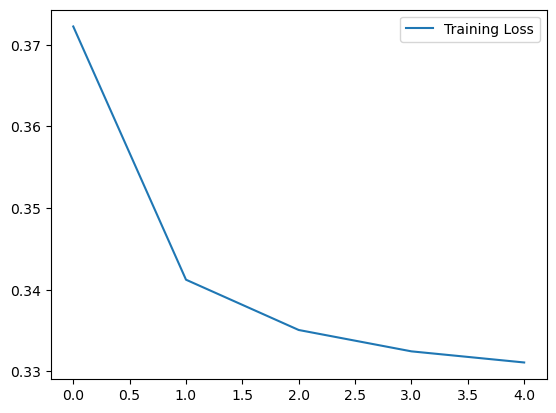

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [19]:
autoencoder.save_weights(f'weights/IMERG_{latent_dim}_downsample.weights.h5')
print("Weights saved successfully.")

Weights saved successfully.


## REOPENING THE MODEL WITH WEIGHTS

In [31]:
ae1 = Autoencoder(latent_dim, shape) 
ae1.predict(train)
ae1.load_weights(f'weights/IMERG_{latent_dim}_downsample.weights.h5')

548/548 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step


In [34]:
[ae1.weights[ii] - autoencoder.weights[ii] for ii in range(len(ae1.weights))]

[<tf.Tensor: shape=(39125, 64), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(64,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(64, 39125), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Ten

#### Loaded weights of the new model match the weights of the original model

# Check whether the distribution of encoded data matches original data

In [ ]:
plt.hist(train[::1000, :])

In [ ]:
pred = ae1.predict(train[::1000])
plt.hist(pred)